# Tutorial - Neural Network - Regression


We will predict the price of an AIRBNB listing (`price` column). This is a regression task.

**The unit of analysis is an AIRBNB LISTING**

# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd

np.random.seed(42)


# Get the data

In [2]:
#We will predict the "price_gte_150" value in the data set:

airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,guests_included,price_per_extra_person,minimum_nights,number_of_reviews,number_days_btw_first_last_review,review_scores_rating,cancellation_policy,price,price_gte_150,price_category
0,0,0,Roslindale,42.282619,-71.133068,House,Entire home/apt,4,1.5,2.0,...,1,0,2,0,0,NaN,moderate,250,1,gte_226
1,0,1,Roslindale,42.286241,-71.134374,Apartment,Private room,2,1.0,1.0,...,0,0,2,36,804,94.0,moderate,65,0,lte_$75
2,1,1,Roslindale,42.292438,-71.135765,Apartment,Private room,2,1.0,1.0,...,1,20,3,41,2574,98.0,moderate,65,0,lte_$75
3,0,0,Roslindale,42.281106,-71.121021,House,Private room,4,1.0,1.0,...,2,25,1,1,0,100.0,moderate,75,0,lte_$75
4,1,1,Roslindale,42.284512,-71.136258,House,Private room,2,1.5,1.0,...,1,0,2,29,380,99.0,flexible,79,0,btw_$75-$150


# Split the data into train and test

In [3]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(airbnb, test_size=0.3)

### Be careful: we haven't seperated the target column yet

## Check the missing values

In [4]:
train_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          2
room_type                              0
accommodates                           0
bathrooms                             10
bedrooms                               8
beds                                   6
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 556
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

In [5]:
test_set.isna().sum()

host_is_superhost                      0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          1
room_type                              0
accommodates                           0
bathrooms                              4
bedrooms                               2
beds                                   3
bed_type                               0
Number of amenities                    0
guests_included                        0
price_per_extra_person                 0
minimum_nights                         0
number_of_reviews                      0
number_days_btw_first_last_review      0
review_scores_rating                 244
cancellation_policy                    0
price                                  0
price_gte_150                          0
price_category                         0
dtype: int64

# Data Prep

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

## Drop the variables we can't use in this tutorial

In [7]:
# We can't use the following columns in this tutorial, because they are not for binary classification tasks

train = train_set.drop(['price_category', 'price_gte_150'], axis=1)
test = test_set.drop(['price_category', 'price_gte_150'], axis=1)

## Separate the target variable (we don't want to transform it)

In [8]:
train_y = train[['price']]
test_y = test[['price']]

train_inputs = train.drop(['price'], axis=1)
test_inputs = test.drop(['price'], axis=1)

## Feature Engineering: Let's derive a new column

In [9]:
# Let's analyze "minimum_nights"

train_inputs['minimum_nights'].describe()

count    2488.000000
mean        2.994775
std         7.105866
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       273.000000
Name: minimum_nights, dtype: float64

In [10]:
train_inputs['minimum_nights'].value_counts()

1      1017
2       666
3       443
4        88
7        82
5        58
10       45
30       18
14       16
15       14
6        12
28        6
20        5
32        3
60        3
9         2
18        1
13        1
8         1
273       1
11        1
21        1
90        1
23        1
17        1
25        1
Name: minimum_nights, dtype: int64

<Axes: >

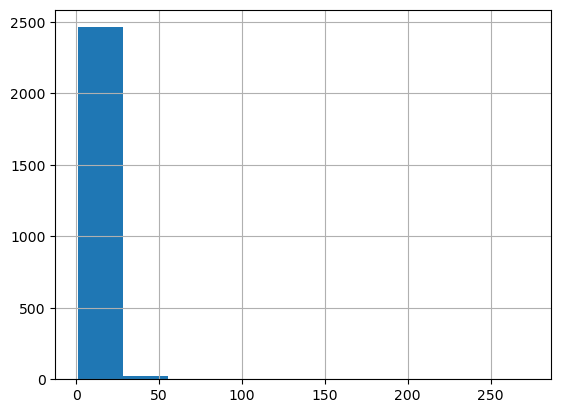

In [11]:
train_inputs['minimum_nights'].hist()

#### Create a new categorical column: convert the minimum nights into 4 categories, equally distributed.

In [12]:
# log transformation helps with fixing skewed distributions

np.log(train_inputs['minimum_nights'])   


1965    0.693147
1450    0.693147
2503    1.609438
944     0.000000
199     0.693147
          ...   
1130    0.000000
1294    1.609438
860     0.000000
3507    0.000000
3174    0.693147
Name: minimum_nights, Length: 2488, dtype: float64

<Axes: >

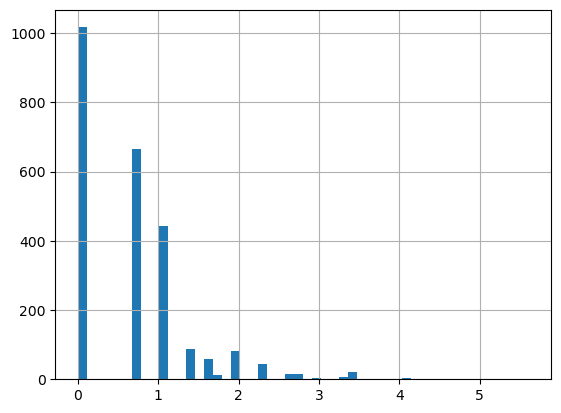

In [28]:
# Let's see the new distribution
np.log(train_inputs['minimum_nights']).hist(bins=50)

# Not great, but we can live with it.

In [29]:
def new_col(df):
    #Create a copy so that we don't overwrite the existing dataframe
    df1 = df.copy()
    
    df1['log_min_nights'] = np.log(df1['minimum_nights']) 
    

    return df1[['log_min_nights']]
    # You can use this to check whether the calculation is made correctly:
    #return df1

##  Identify the numerical and categorical columns

In [30]:
train_inputs.dtypes

host_is_superhost                      int64
host_identity_verified                 int64
neighbourhood_cleansed                object
latitude                             float64
longitude                            float64
property_type                         object
room_type                             object
accommodates                           int64
bathrooms                            float64
bedrooms                             float64
beds                                 float64
bed_type                              object
Number of amenities                    int64
guests_included                        int64
price_per_extra_person                 int64
minimum_nights                         int64
number_of_reviews                      int64
number_days_btw_first_last_review      int64
review_scores_rating                 float64
cancellation_policy                   object
dtype: object

**At this stage, you can manually identify numeric, binary, and categorical columns as follows:**

`numeric_columns = ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'Number of amenities', 'guests_included', 'price_per_extra_person', 'minimum_nights', 'number_of_reviews', 'number_days_btw_first_last_review', 'review_scores_rating']`
 
 `binary_columns = ['host_is_superhost', 'host_identity_verified']`
 
 `categorical_columns = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']`
 
<br>
 
**If you do not want to manually type these, you can do the below tricks:**

In [31]:
# Identify the numerical columns
numeric_columns = train_inputs.select_dtypes(include=[np.number]).columns.to_list()

# Identify the categorical columns
categorical_columns = train_inputs.select_dtypes('object').columns.to_list()

In [32]:
# Identify the binary columns so we can pass them through without transforming
binary_columns = ['host_is_superhost', 'host_identity_verified']

In [33]:
# Be careful: numerical columns already includes the binary columns,
# So, we need to remove the binary columns from numerical columns.

for col in binary_columns:
    numeric_columns.remove(col)

In [34]:
binary_columns

['host_is_superhost', 'host_identity_verified']

In [35]:
numeric_columns

['latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'Number of amenities',
 'guests_included',
 'price_per_extra_person',
 'minimum_nights',
 'number_of_reviews',
 'number_days_btw_first_last_review',
 'review_scores_rating']

In [36]:
categorical_columns

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [37]:
transformed_columns = ['minimum_nights']

# Pipeline

In [38]:
numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())])

In [39]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [40]:
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [41]:
my_new_column = Pipeline(steps=[('my_new_column', FunctionTransformer(new_col)),
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

In [42]:
preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns),
        ('binary', binary_transformer, binary_columns),
        ('trans', my_new_column, transformed_columns)],
        remainder='passthrough')

#passtrough is an optional step. You don't have to use it.

# Transform: fit_transform() for TRAIN

In [43]:
#Fit and transform the train data
train_x = preprocessor.fit_transform(train_inputs)

train_x

array([[ 0.82254842,  0.69215829,  0.54753414, ...,  1.        ,
         1.        ,  0.02198434],
       [ 0.55146572,  0.15729058,  0.54753414, ...,  0.        ,
         1.        ,  0.02198434],
       [ 0.07311286, -1.97951247, -0.59100739, ...,  0.        ,
         0.        ,  1.25868911],
       ...,
       [-0.61093878, -0.07631528,  3.96315871, ...,  0.        ,
         1.        , -0.91354671],
       [ 1.17819153, -0.94575177, -1.16027815, ...,  0.        ,
         0.        , -0.91354671],
       [-0.33618088,  1.03587419, -0.59100739, ...,  0.        ,
         1.        ,  0.02198434]])

In [44]:
train_x.shape

(2488, 67)

# Tranform: transform() for TEST

In [45]:
# Transform the test data
test_x = preprocessor.transform(test_inputs)

test_x

array([[-1.21269719, -1.20324989,  0.54753414, ...,  0.        ,
         1.        ,  0.02198434],
       [-2.86419979, -2.67831359, -0.59100739, ...,  0.        ,
         0.        , -0.91354671],
       [-0.11443035,  1.26295963, -0.59100739, ...,  0.        ,
         1.        , -0.91354671],
       ...,
       [ 0.47803436, -1.63486781, -0.59100739, ...,  1.        ,
         1.        , -0.91354671],
       [ 0.59928397,  0.34795157,  2.82461719, ...,  0.        ,
         0.        ,  0.02198434],
       [ 0.19953968,  0.22845713, -0.59100739, ...,  0.        ,
         1.        ,  1.71282097]])

In [46]:
test_x.shape

(1067, 67)

# Calculate the baseline

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
#First find the average value of the target

mean_value = np.mean(train_y['price'])

mean_value

168.17966237942122

In [49]:
# Predict all values as the mean

baseline_pred = np.repeat(mean_value, len(test_y))

baseline_pred

array([168.17966238, 168.17966238, 168.17966238, ..., 168.17966238,
       168.17966238, 168.17966238])

In [50]:
baseline_mse = mean_squared_error(test_y, baseline_pred)

baseline_rmse = np.sqrt(baseline_mse)

print('Baseline RMSE: {}' .format(baseline_rmse))

Baseline RMSE: 102.31125032666752


# Calculate the baseline - new approach (not included in the tutorial video)

**This section is not included in the tutorial video. Though, it is a better (and a more foolproof) way of calculating the baseline. I recommend using this approach rather than the above approach.**

**Note that it generates the same results as the above approach.**

In [51]:
# Sci-kit Learn's DummyRegressor automates the entire process performed manually above.
# First, you instantiate it with the "mean" strategy. 
# Then, you fit the model. This finds the mean value of the target (in the training set).

from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(train_x, train_y)

DummyRegressor()

In [52]:
from sklearn.metrics import mean_squared_error

In [53]:
# Then, you call the predict function of the regressor.
# This predicts all values as the mean value.
# In the next step, you compare the predicted values with the actual values to calculate mean squared error
# Taking the square root gives you "root mean squared error"
# This is the baseline Train RMSE

dummy_train_pred = dummy_regr.predict(train_x)

baseline_train_mse = mean_squared_error(train_y, dummy_train_pred)

baseline_train_rmse = np.sqrt(baseline_train_mse)

print('Baseline Train RMSE: {}' .format(baseline_train_rmse))

Baseline Train RMSE: 103.84299127618122


In [54]:
# We repeat the same steps for the test set
# This is the baseline Test RMSE

dummy_test_pred = dummy_regr.predict(test_x)

baseline_test_mse = mean_squared_error (test_y, dummy_test_pred)

baseline_test_rmse = np.sqrt(baseline_test_mse)

print('Baseline Test RMSE: {}' .format(baseline_test_rmse))

Baseline Test RMSE: 102.31125032666752


# Train the model



In [55]:
from sklearn.neural_network import MLPRegressor

#Default settings create 1 hidden layer with 100 neurons
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,))

mlp_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [56]:
#Train RMSE
train_pred = mlp_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 59.90189253483679


In [57]:
#Test RMSE
test_pred = mlp_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 60.23272974738864


## Increase maximum iterations for convergence

In [58]:
#Default settings create 1 hidden layer with 100 neurons
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000)

mlp_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=1000)

In [59]:
#Train RMSE
train_pred = mlp_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 45.44955923526663


In [60]:
#Test RMSE
test_pred = mlp_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 60.49358231532862


# Deep Neural Network

In [61]:
dnn_reg = MLPRegressor(hidden_layer_sizes=(50,50,50,50,50),
                       max_iter=1000)

dnn_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(50, 50, 50, 50, 50), max_iter=1000)

In [62]:
#Train RMSE
train_pred = dnn_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 16.861555782738687


In [63]:
#Test RMSE
test_pred = dnn_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 73.4493585621259


## Early stopping

In [64]:
dnn_reg = MLPRegressor(hidden_layer_sizes=(50,50,50),
                       max_iter=1000,
                       early_stopping=True)

dnn_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(early_stopping=True, hidden_layer_sizes=(50, 50, 50),
             max_iter=1000)

In [65]:
#Train RMSE
train_pred = dnn_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 54.70318081917079


In [66]:
#Test RMSE
test_pred = dnn_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 61.17687996984172


## Regularization

In [67]:
dnn_reg = MLPRegressor(hidden_layer_sizes=(50,50,50),
                       max_iter=1000,
                       early_stopping=True,
                      alpha = 0.1)

dnn_reg.fit(train_x, train_y)

C:\Users\mural\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(alpha=0.1, early_stopping=True, hidden_layer_sizes=(50, 50, 50),
             max_iter=1000)

In [68]:
#Train RMSE
train_pred = dnn_reg.predict(train_x)

train_mse = mean_squared_error(train_y, train_pred)

train_rmse = np.sqrt(train_mse)

print('Train RMSE: {}' .format(train_rmse))

Train RMSE: 55.86101010615475


In [69]:
#Test RMSE
test_pred = dnn_reg.predict(test_x)

test_mse = mean_squared_error(test_y, test_pred)

test_rmse = np.sqrt(test_mse)

print('Test RMSE: {}' .format(test_rmse))

Test RMSE: 60.32046814209459
